In [2]:
#import nessecary libraries
import numpy as np
from PIL import Image, ImageFont, ImageDraw
from skimage import io, filters
import matplotlib.pyplot as plt
from skimage.io import imread, imsave, imshow, show, imread_collection, imshow_collection
from IPython.display import display
import cv2
from skimage.filters import try_all_threshold
from skimage import data
from skimage.filters import threshold_li
from skimage.feature import canny
from skimage.transform import hough_circle, hough_circle_peaks
from skimage.draw import circle_perimeter
import skimage as ski
from skimage.measure import label, regionprops
from skimage.filters import threshold_otsu



In [3]:
#Outline
#1. use the multicompartiment model to segment glomeruli or anotate using imagescope
#2. use tiffslide to open the regions
#3. view the thumbnails
#4. turn gray
#5. threshold
#6. inverse
#7. identify areas and overlay the podocyte images
#8. overlay to the bigger image


In [4]:
import tiffslide
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import threshold_li
from lxml import etree



# File paths
slide_path = './Images/JPH10.svs'  # Add the path to your whole slide image
json_path = './Images/glomsJPH10.json'






In [5]:
import json

def parse_json(json_file):
    with open(json_file, 'r') as f:
        data = json.load(f)
    tiles = []
    for element in data['annotation']['elements']:
        points = element['points']
        x_coords = [point[0] for point in points]
        y_coords = [point[1] for point in points]
        x_min, x_max = min(x_coords), max(x_coords)
        y_min, y_max = min(y_coords), max(y_coords)
        width = int(x_max - x_min)
        height = int(y_max - y_min)
        tiles.append((int(x_min), int(y_min), width, height))
    return tiles

tiles = parse_json(json_path)
#print(tiles)


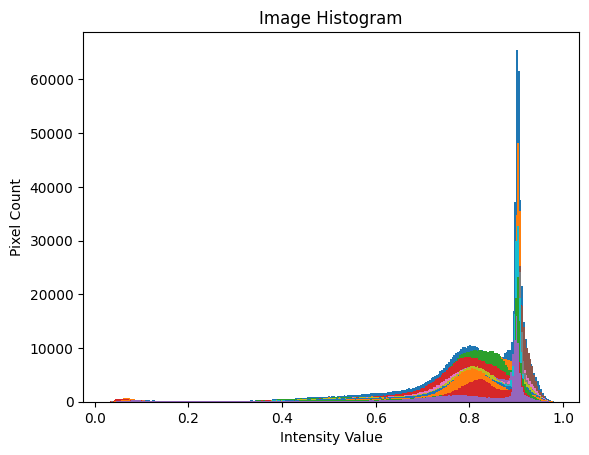

In [6]:
#plot the images histograams to understand the density distribution
import matplotlib.pyplot as plt
from skimage import data, exposure
import xml.etree.ElementTree as ET
from tiffslide import TiffSlide
from xml.dom import minidom
slide = TiffSlide(slide_path)

for (x, y, width, height) in tiles:
        #print(f"Processing tile at ({x}, {y}) with size ({width}x{height})")
        tile = slide.read_region((x, y), 0, (width, height)).convert("RGB")
        tile_array = np.array(tile)
        tile_array= filters.gaussian(tile_array, sigma=1.3)
        gray_tile = np.dot(tile_array[..., :3], [0.2989, 0.5870, 0.1140])  # Convert to grayscale

        # Calculate and plot the histogram
        hist, bins = exposure.histogram(gray_tile)
        plt.hist(bins[:-1], bins, weights=hist[:-1])  # Slice 'hist' as well
        plt.title("Image Histogram")
        plt.xlabel("Intensity Value")
        plt.ylabel("Pixel Count")
       # plt.show()
#if 0.3 value is common to all tiles, why can't we use it?

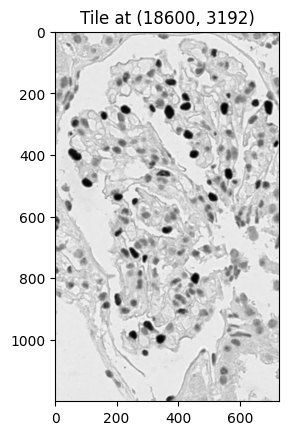

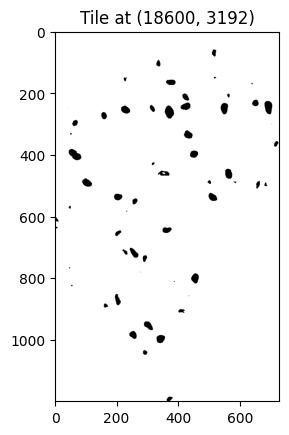

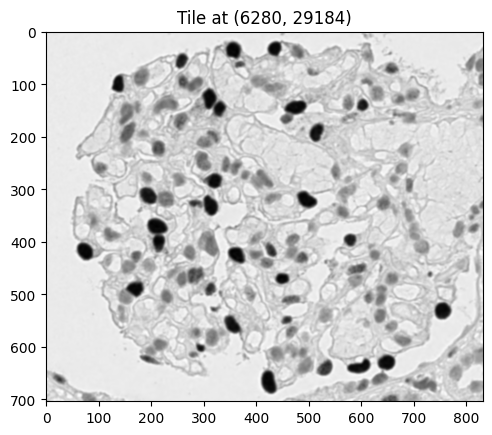

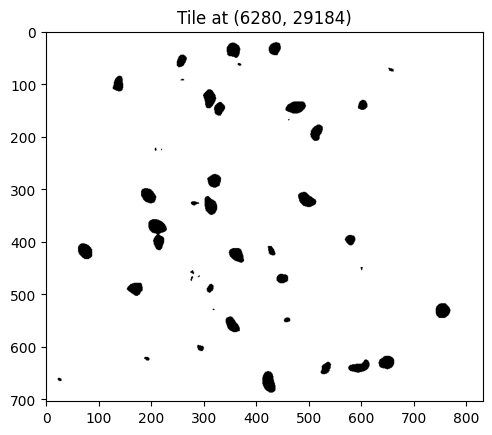

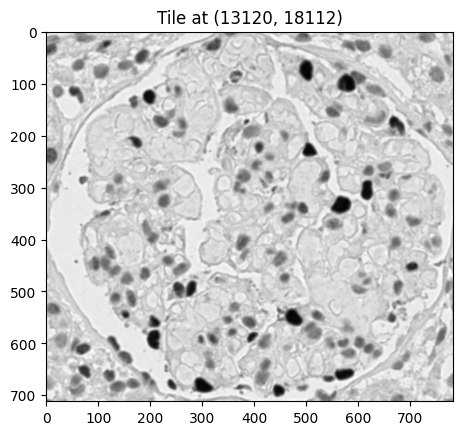

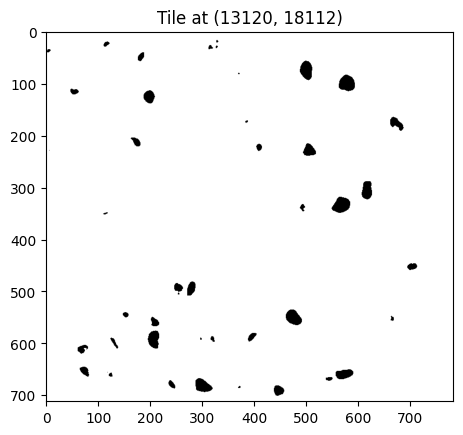

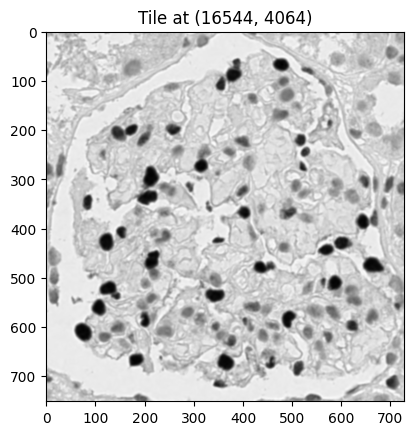

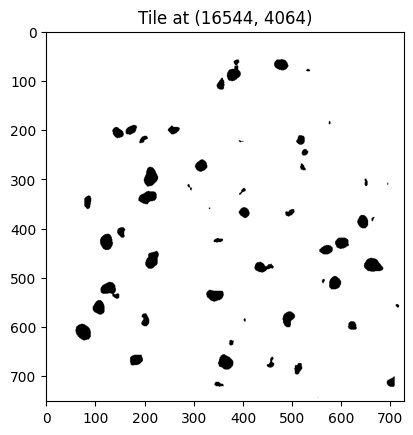

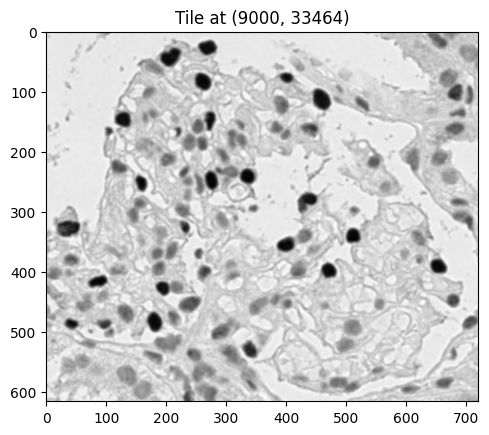

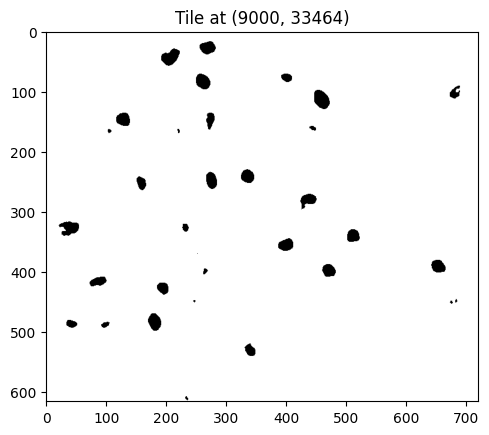

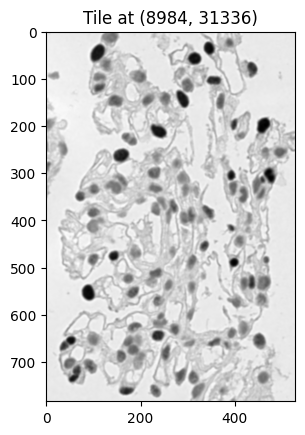

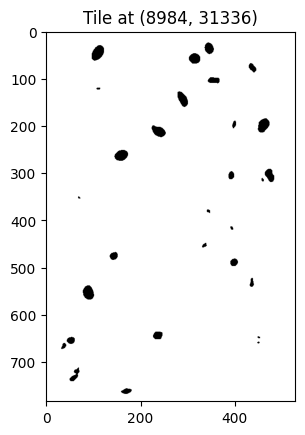

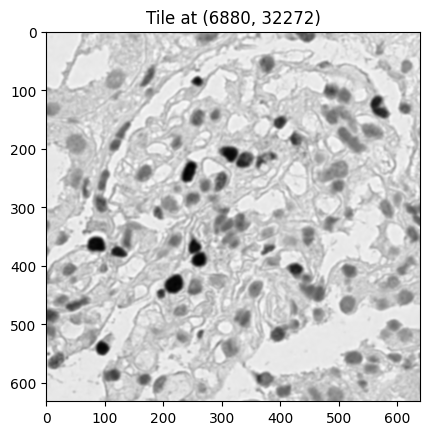

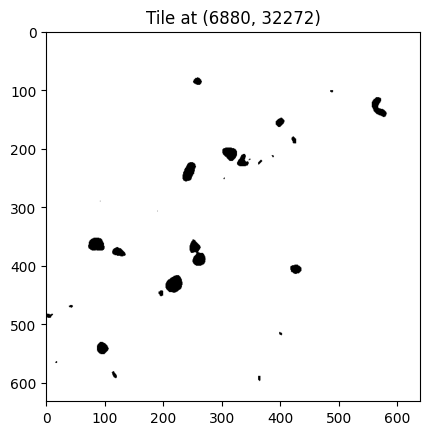

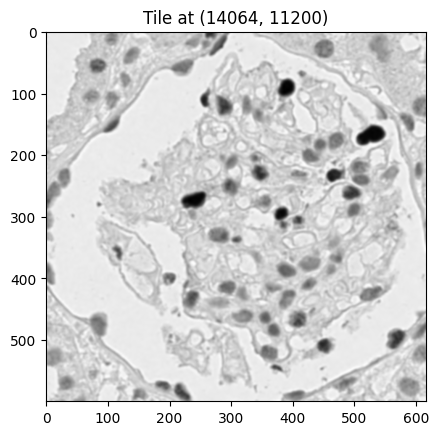

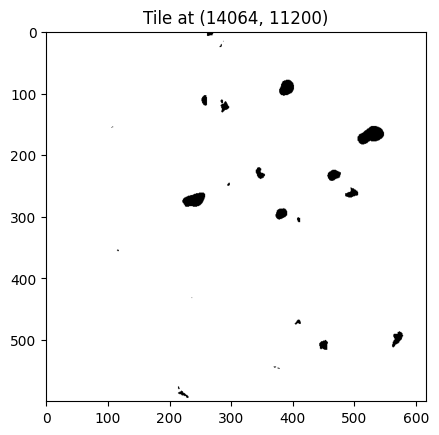

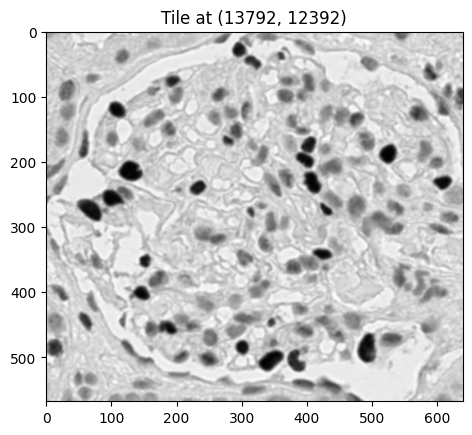

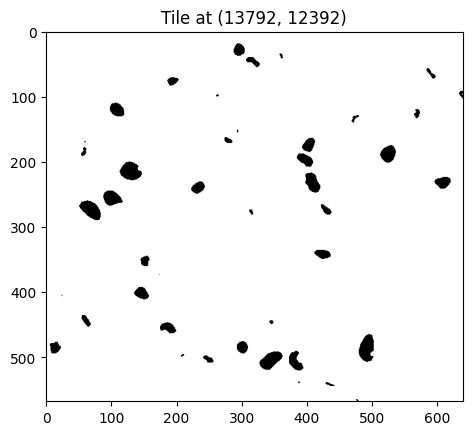

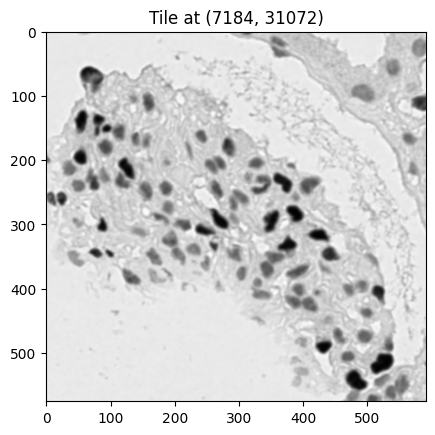

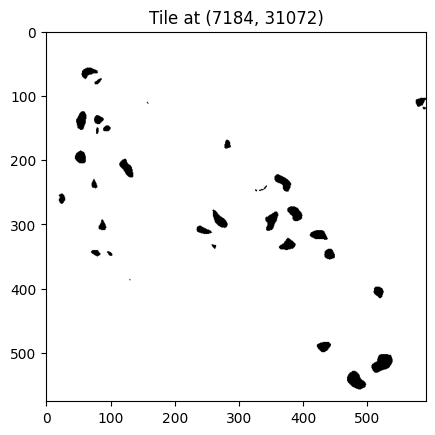

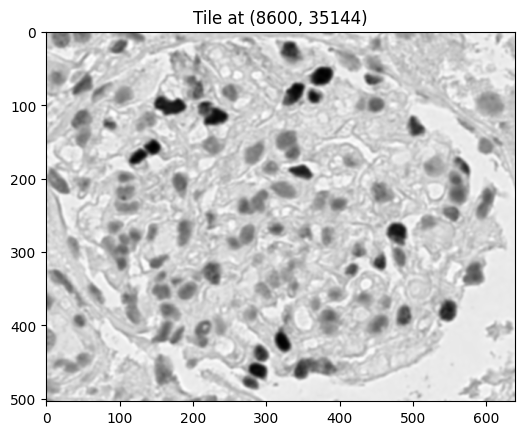

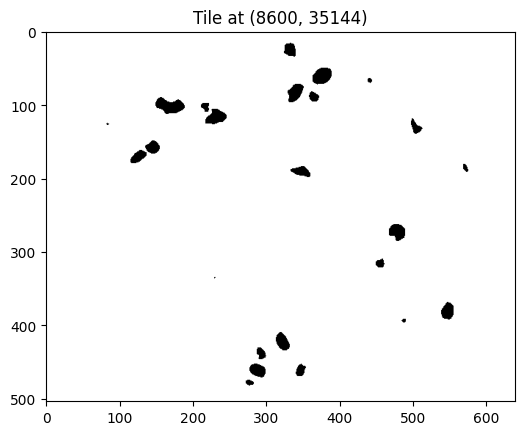

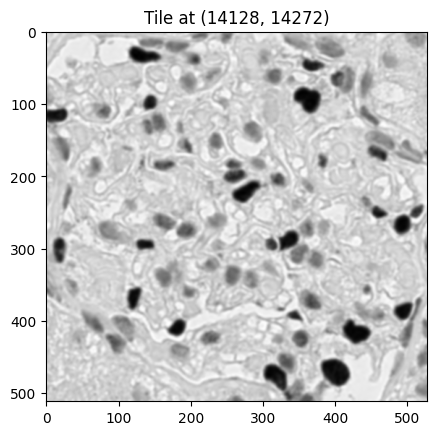

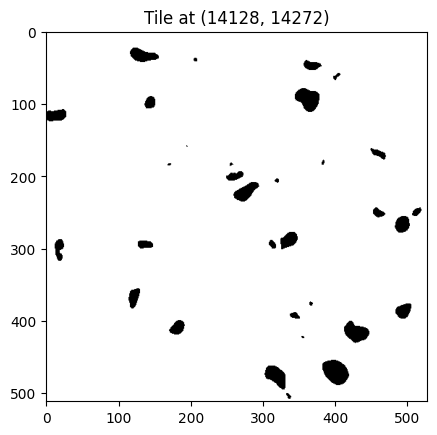

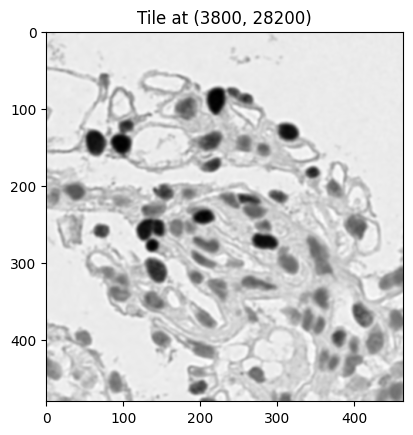

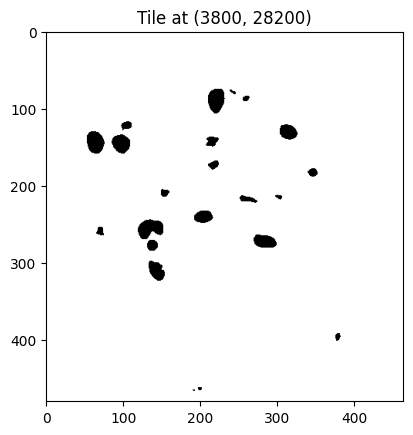

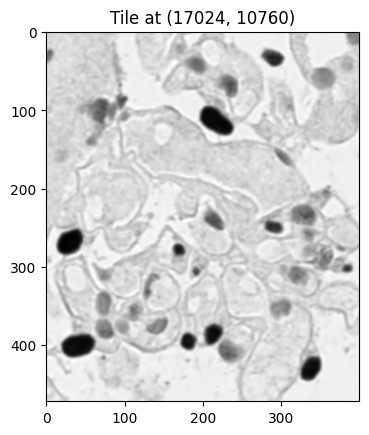

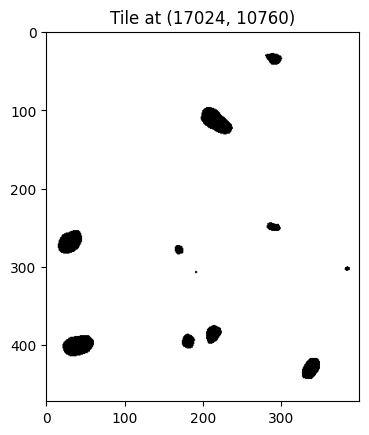

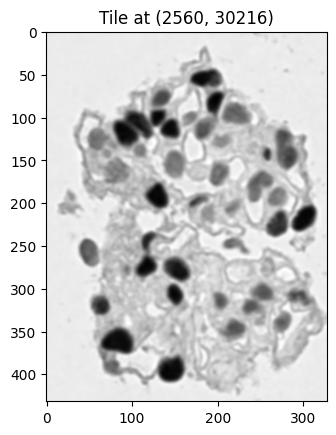

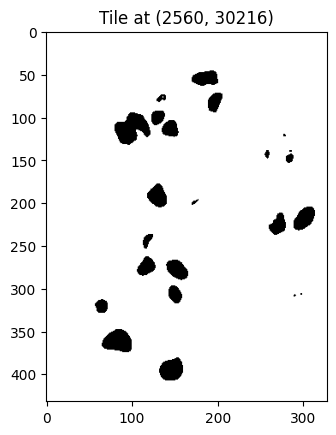

In [7]:
# Function to extract and threshold tiles
def process_tiles(slide, tiles):
    thresh_tiles=[]
    for (x, y, width, height) in tiles:
        #print(f"Processing tile at ({x}, {y}) with size ({width}x{height})")
        tile = slide.read_region((x, y), 0, (width, height)).convert("RGB")
        tile_array = np.array(tile)
        tile_array= filters.gaussian(tile_array, sigma=1.3)
        gray_tile = np.dot(tile_array[..., :3], [0.2989, 0.5870, 0.1140])  # Convert to grayscale
        initial_guess = threshold_otsu(gray_tile)
        li_thresh = threshold_li(gray_tile, initial_guess= initial_guess)
        binary_tile = gray_tile > 0.3   #use 0.3 instead of Li's threshold
        plt.figure()
        plt.title(f"Tile at ({x}, {y})")
        plt.imshow(gray_tile, cmap='gray')
        plt.show()
        
        
        plt.figure()
        plt.title(f"Tile at ({x}, {y})")
        plt.imshow(binary_tile, cmap='gray')
        plt.show()
        thresh_tiles.append((x,y,width, height, binary_tile))
    return thresh_tiles
thresh_tiles = process_tiles(slide, tiles)


In [8]:
"""import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi

from skimage.segmentation import watershed
from skimage.feature import peak_local_max

def watersheds(thresh_tiles):
    for (x, y, width, height, im_thresh) in thresh_tiles:
        im_thresh= np.array(im_thresh)                  #read it as a numpy array
        im_thresh= ski.util.invert(im_thresh)          #invert the image
        
        # Now we want to separate the two objects in image
        # Generate the markers as local maxima of the distance to the background
        distance = ndi.distance_transform_edt(im_thresh)
        coords = peak_local_max(distance, footprint=np.ones((3, 3)), labels=im_thresh)
        mask = np.zeros(distance.shape, dtype=bool)
        mask[tuple(coords.T)] = True
        markers, _ = ndi.label(mask)
        labels = watershed(-distance, markers, mask=im_thresh)

        fig, axes = plt.subplots(ncols=3, figsize=(9, 3), sharex=True, sharey=True)
        ax = axes.ravel()

        ax[0].imshow(im_thresh, cmap=plt.cm.gray)
        ax[0].set_title('Overlapping objects')
        ax[1].imshow(-distance, cmap=plt.cm.gray)
        ax[1].set_title('Distances')
        ax[2].imshow(labels, cmap=plt.cm.nipy_spectral)
        ax[2].set_title('Separated objects')

        for a in ax:
            a.set_axis_off()

        fig.tight_layout()
        plt.show()
watersheds(thresh_tiles)"""

"import numpy as np\nimport matplotlib.pyplot as plt\nfrom scipy import ndimage as ndi\n\nfrom skimage.segmentation import watershed\nfrom skimage.feature import peak_local_max\n\ndef watersheds(thresh_tiles):\n    for (x, y, width, height, im_thresh) in thresh_tiles:\n        im_thresh= np.array(im_thresh)                  #read it as a numpy array\n        im_thresh= ski.util.invert(im_thresh)          #invert the image\n        \n        # Now we want to separate the two objects in image\n        # Generate the markers as local maxima of the distance to the background\n        distance = ndi.distance_transform_edt(im_thresh)\n        coords = peak_local_max(distance, footprint=np.ones((3, 3)), labels=im_thresh)\n        mask = np.zeros(distance.shape, dtype=bool)\n        mask[tuple(coords.T)] = True\n        markers, _ = ndi.label(mask)\n        labels = watershed(-distance, markers, mask=im_thresh)\n\n        fig, axes = plt.subplots(ncols=3, figsize=(9, 3), sharex=True, sharey=Tr

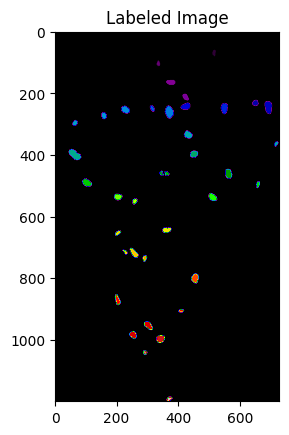

The number of podocytes in this image is: 38


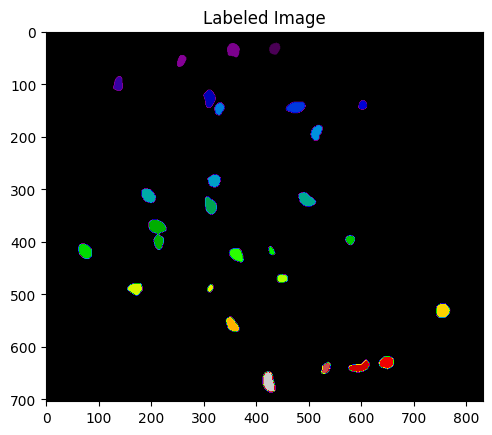

The number of podocytes in this image is: 27


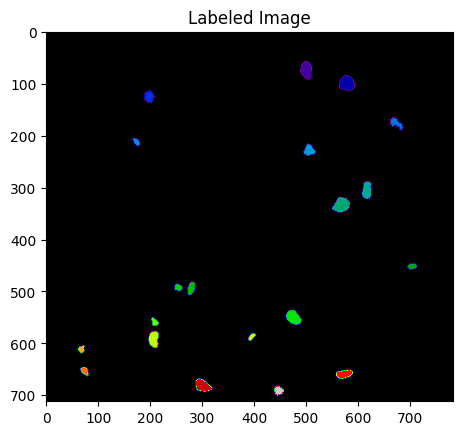

The number of podocytes in this image is: 20


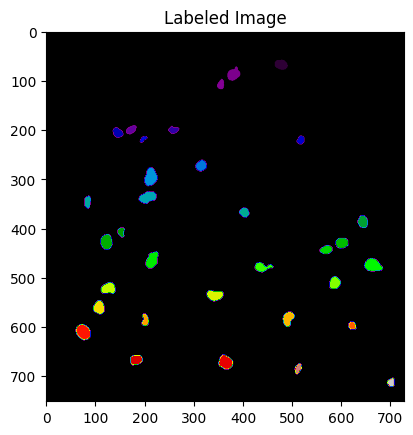

The number of podocytes in this image is: 33


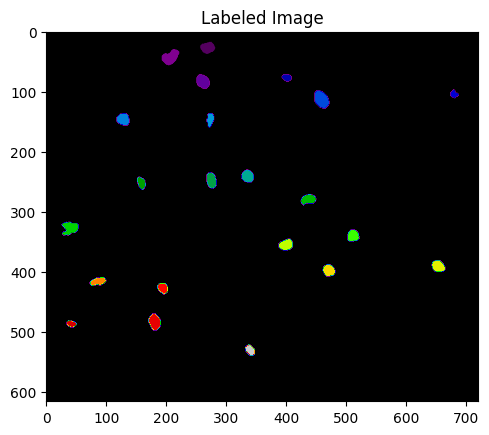

The number of podocytes in this image is: 22


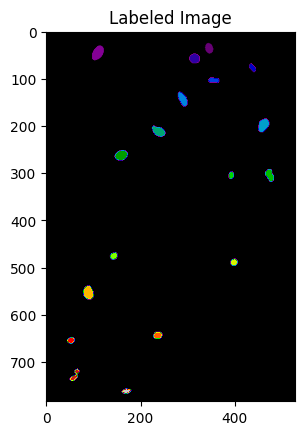

The number of podocytes in this image is: 18


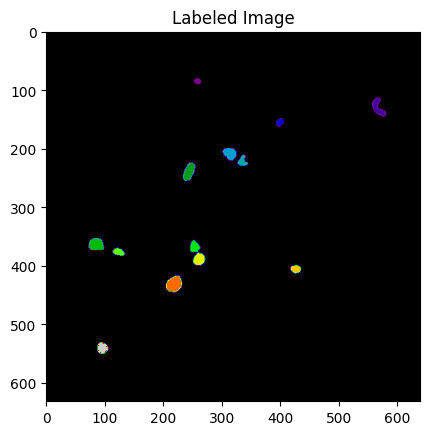

The number of podocytes in this image is: 13


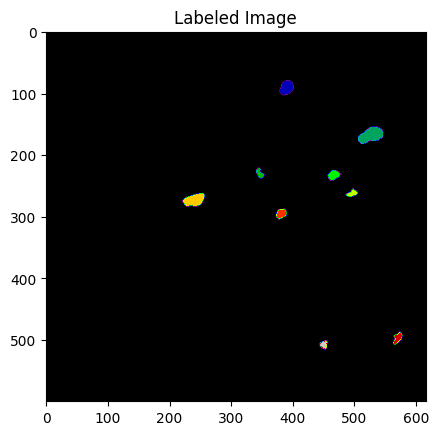

The number of podocytes in this image is: 9


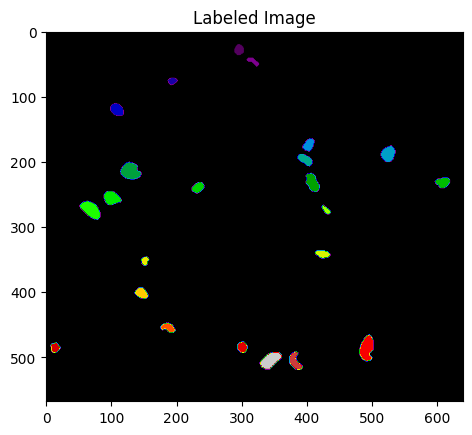

The number of podocytes in this image is: 23


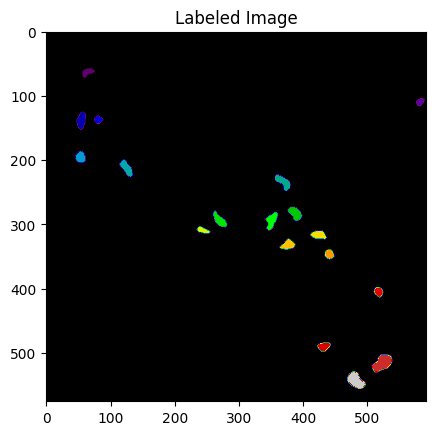

The number of podocytes in this image is: 18


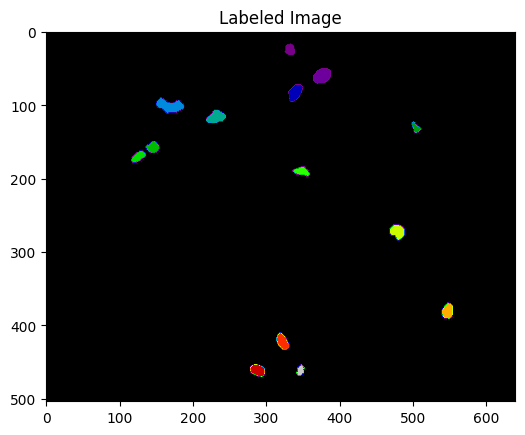

The number of podocytes in this image is: 14


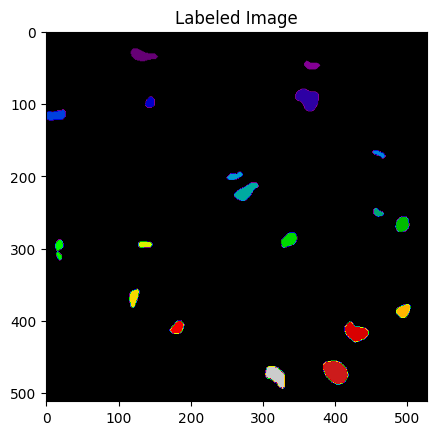

The number of podocytes in this image is: 19


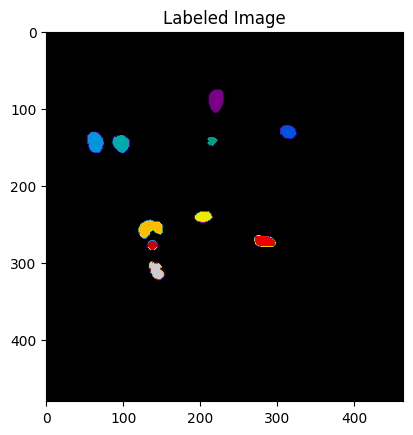

The number of podocytes in this image is: 10


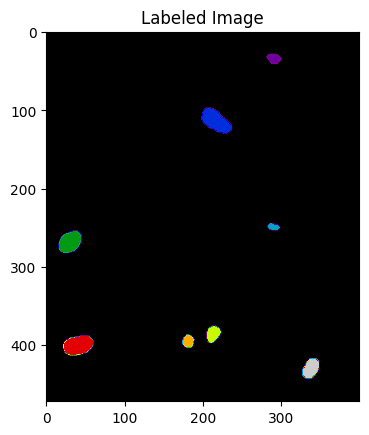

The number of podocytes in this image is: 8


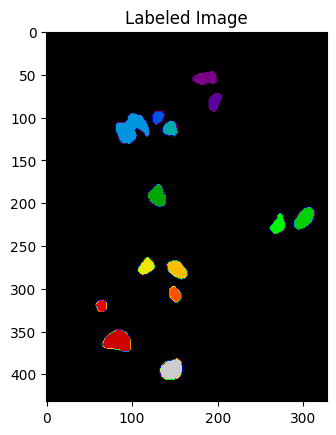

The number of podocytes in this image is: 14


In [9]:
import skimage.morphology as morph

def countRegions(thresh_tiles):
    results=[]
    for (x, y, width, height, im_thresh) in thresh_tiles:
        im_thresh= np.array(im_thresh)                  #read it as a numpy array
        im_thresh_inv= ski.util.invert(im_thresh)          #invert the image
        
        selem = morph.disk(1)
        eroded = morph.binary_erosion(im_thresh_inv)
        i=0
        for i in range(2):
            selem = morph.disk(1)
            eroded = morph.binary_erosion(eroded)
            i+=1

        selem = morph.disk(2)
        dilated= morph.binary_dilation(eroded, selem)        
        label_image = label(dilated)                 # label the regions

        for region in regionprops(label_image):                          #label the areas
            if region.area < 100:
                for coordinates in region.coords:
                    label_image[coordinates[0], coordinates[1]] = 0
        im_thresh_inv_arr = label_image > 0
        Podocount = 0
        for region in regionprops(label_image):
            Podocount +=1                                  #Count Podocytes
        # check if it is labeling correctly  for debugging purposes
        plt.imshow(label_image, cmap='nipy_spectral')
        plt.title('Labeled Image')

        plt.show()
        cleanIm = Image.fromarray(im_thresh_inv_arr)
        print("The number of podocytes in this image is:", Podocount)
        results.append((x, y, width, height,im_thresh_inv_arr))
    return results
tile_result=countRegions(thresh_tiles)

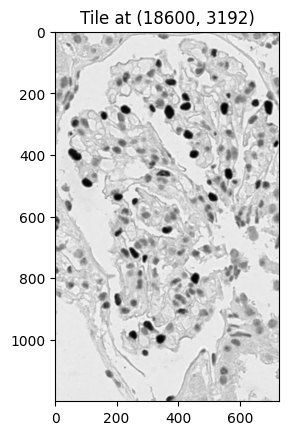

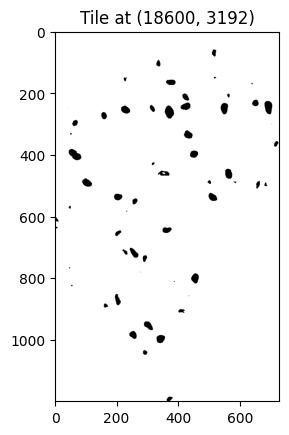

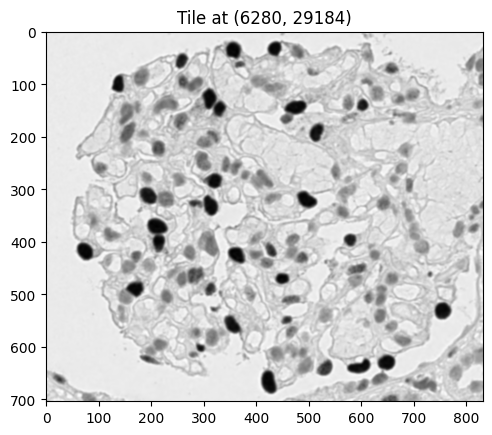

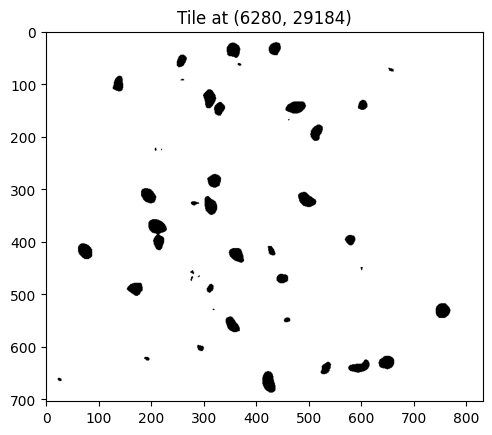

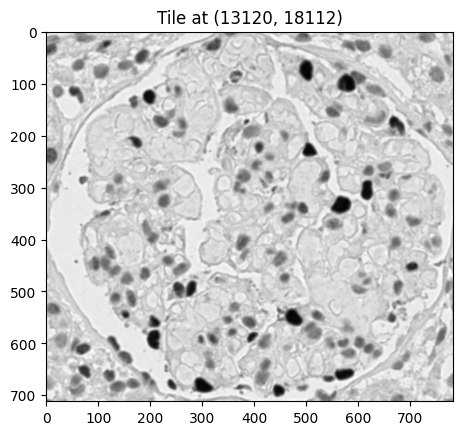

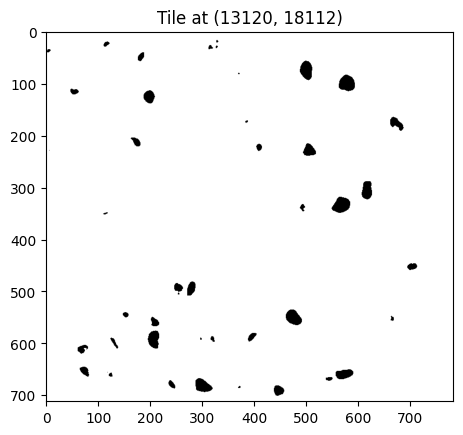

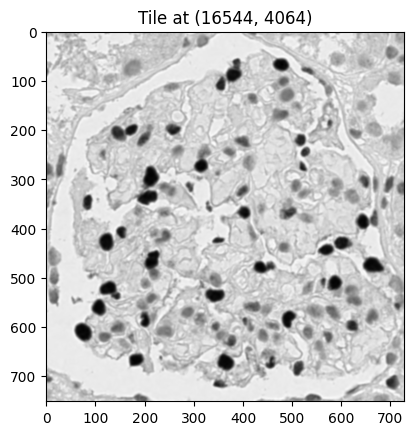

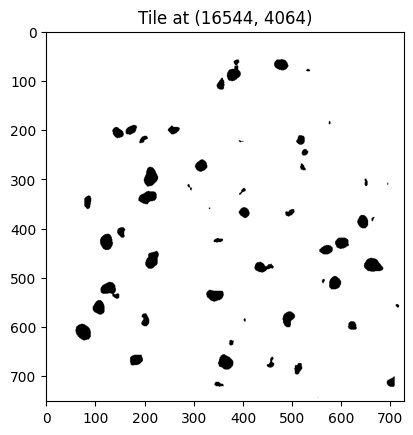

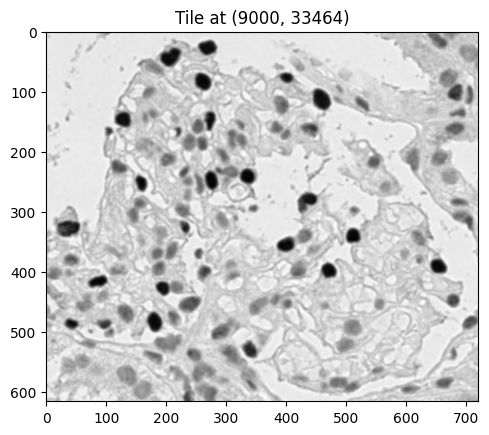

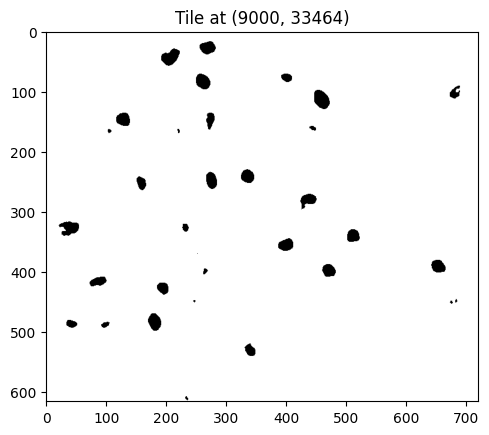

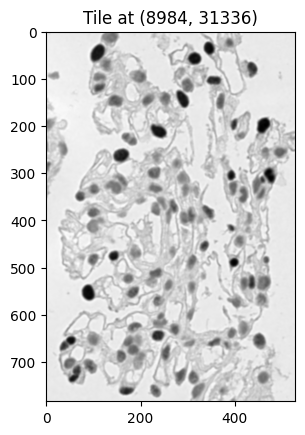

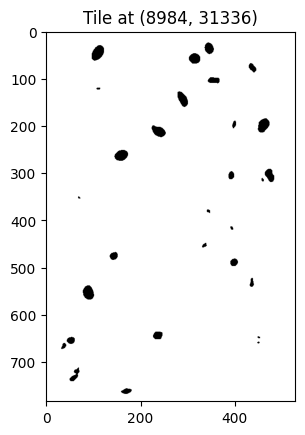

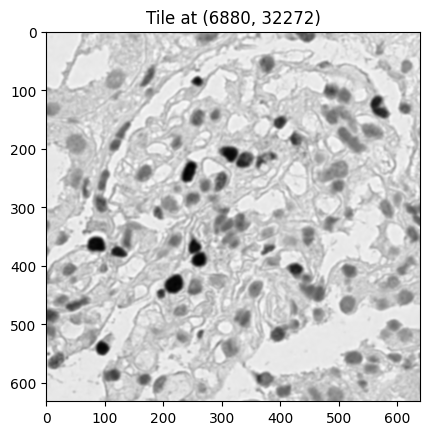

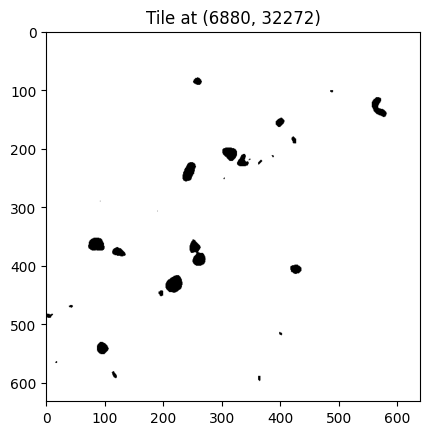

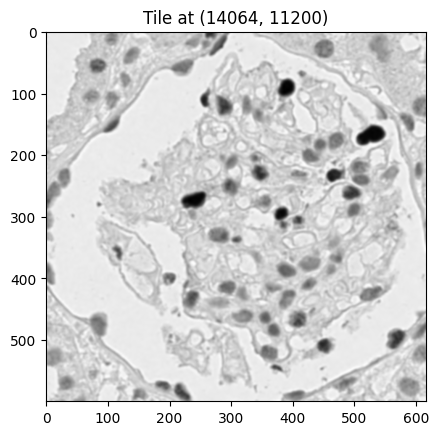

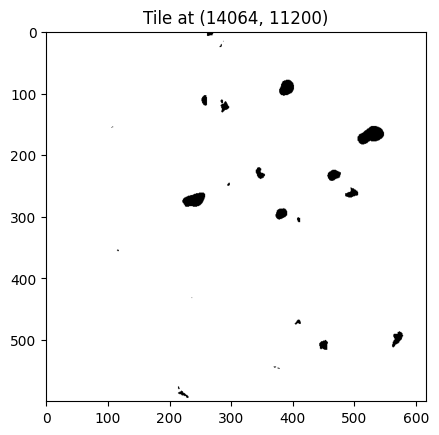

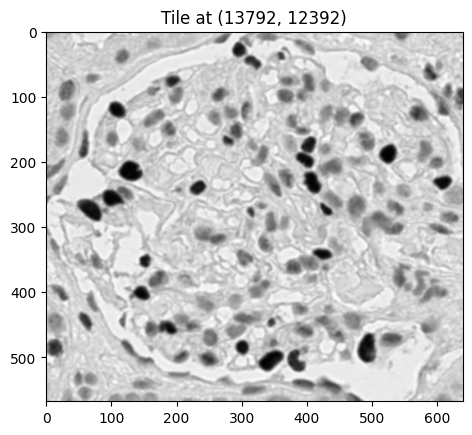

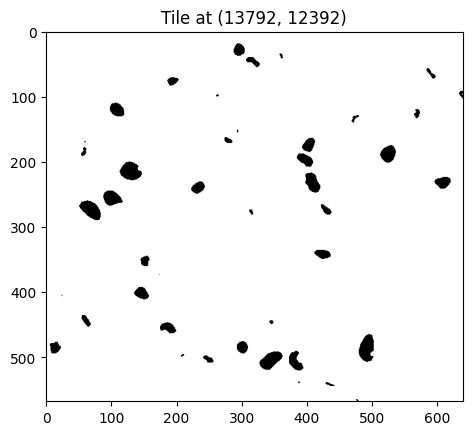

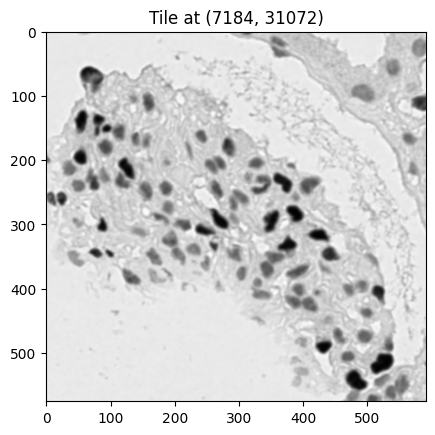

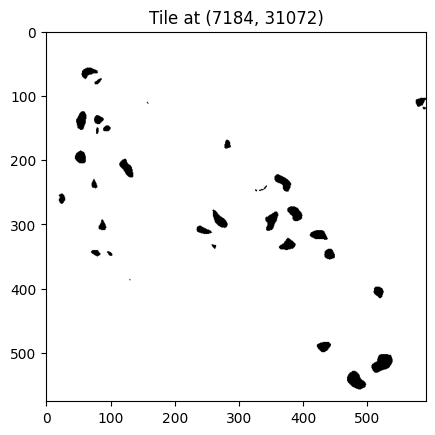

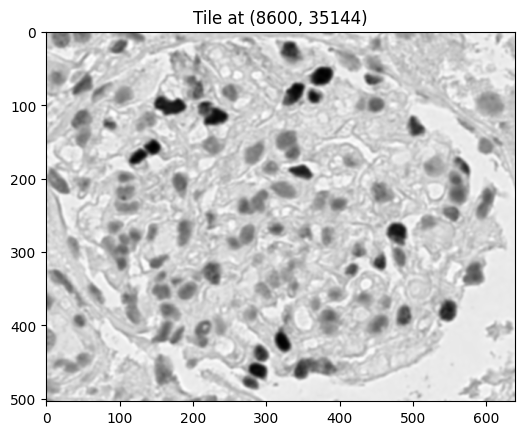

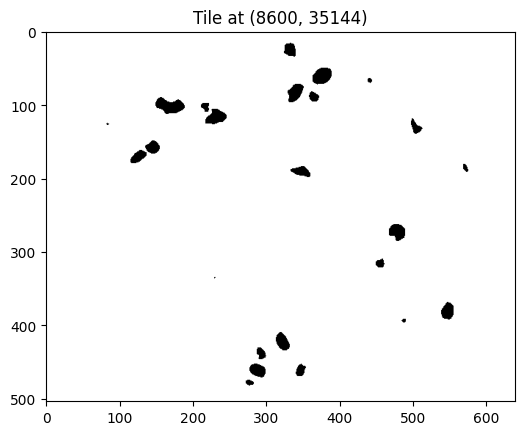

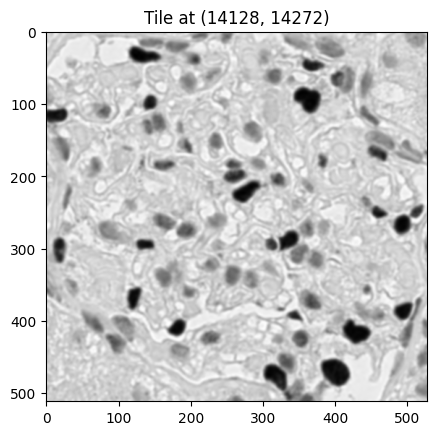

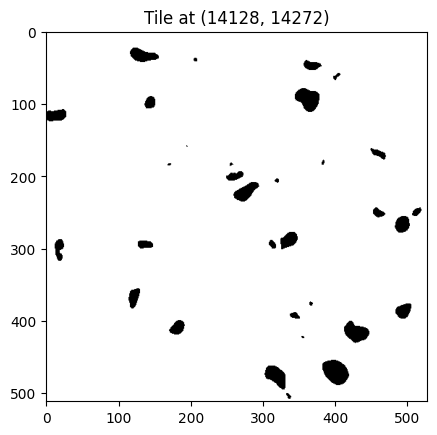

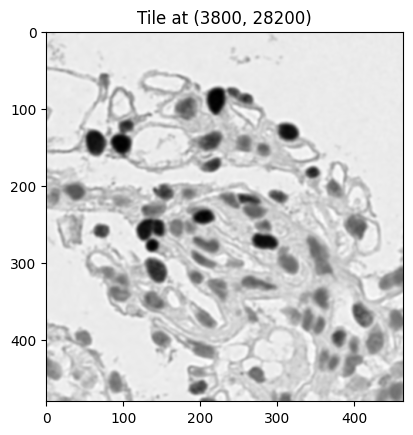

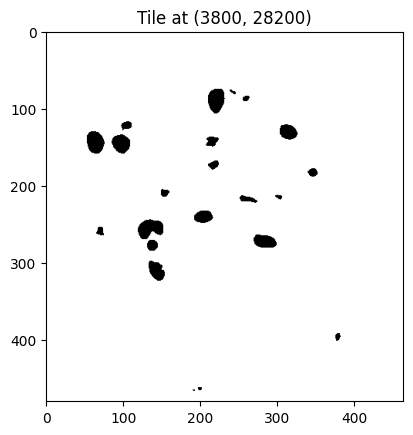

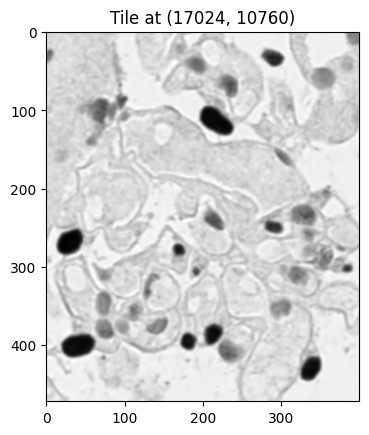

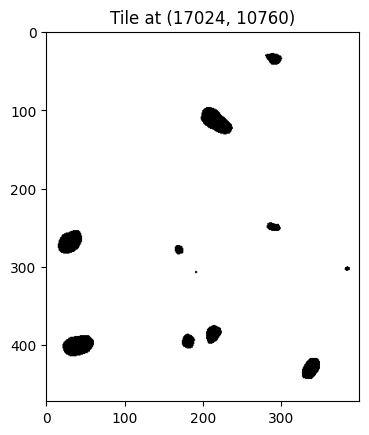

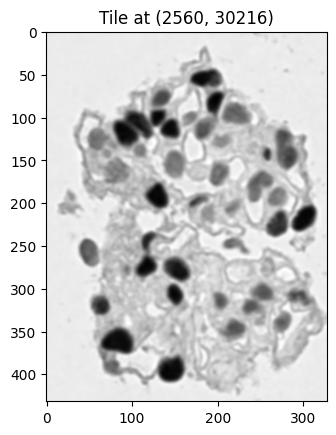

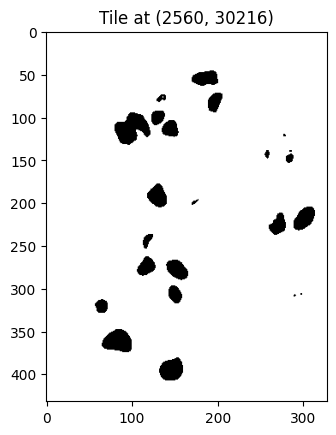

Annotation XML created successfully.


In [12]:
from skimage import filters, morphology, measure
from tiffslide import TiffSlide
from lxml import etree
import xml.etree.ElementTree as ET

def create_annotation_xml(tile_results, output_xml):
    annotations = ET.Element("Annotations", MicronsPerPixel="0.251800")
    annotation_id = 1

    for (x, y, width, height, binary_tile) in tile_results:
        label_image = label(binary_tile)
        for region in regionprops(label_image):
            if region.area < 100:
                continue

            annotation = ET.SubElement(annotations, "Annotation", Id=str(annotation_id), Type="4", LineColor="65280", Visible="1", Selected="1")
            attributes = ET.SubElement(annotation, "Attributes")
            ET.SubElement(attributes, "Attribute", Name="Description", Id="0", Value="")
            
            regions = ET.SubElement(annotation, "Regions")
            region_element = ET.SubElement(regions, "Region", Id=str(annotation_id), Type="0", Zoom="1", Selected="0", ImageLocation="", ImageFocus="-1", Length="0", Area="0", LengthMicrons="0", AreaMicrons="0", Text="", NegativeROA="0", InputRegionId="0", Analyze="1", DisplayId="1")
            vertices = ET.SubElement(region_element, "Vertices")

            for coord in region.coords:
                vertex_x = x + coord[1]  # Adjust for the whole slide coordinates
                vertex_y = y + coord[0]
                ET.SubElement(vertices, "Vertex", X=str(vertex_x), Y=str(vertex_y))

            annotation_id += 1

    tree = ET.ElementTree(annotations)
    tree.write(output_xml, encoding="UTF-8", xml_declaration=True)




output_xml = './Images/JPH10_annotations.xml'  # Path to save the new XML file

thresh_tiles = process_tiles(slide, tiles)
create_annotation_xml(tile_result, output_xml)

print("Annotation XML created successfully.")

In [ ]:
#Next step
#produce an overlay image

#Notes
#Maybe use color deconvolution 